In [1]:
import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.analysis import polymer_analyses, contact_maps
from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 5287


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate a chromosome comprised of 15000 monomers, with number density 0.2
density = 0.2
chromosome_sizes = [15000]

In [6]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [7]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))

In [8]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes, monomer_type_list=['A'])

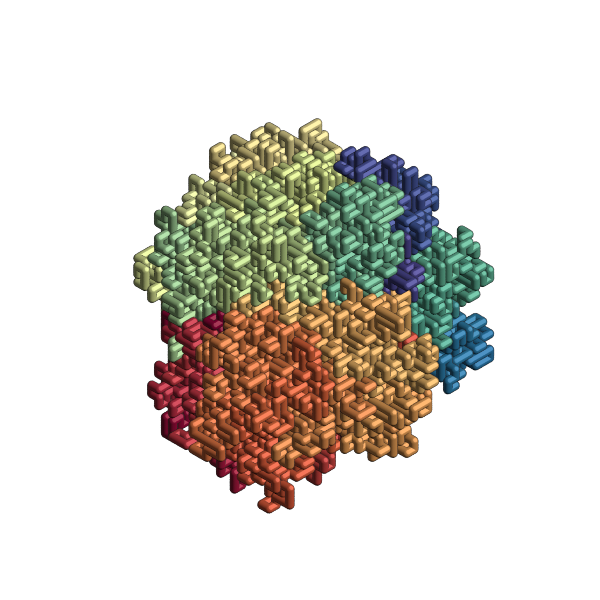

In [9]:
# Quickly visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="Spectral").static(pathtrace=False)

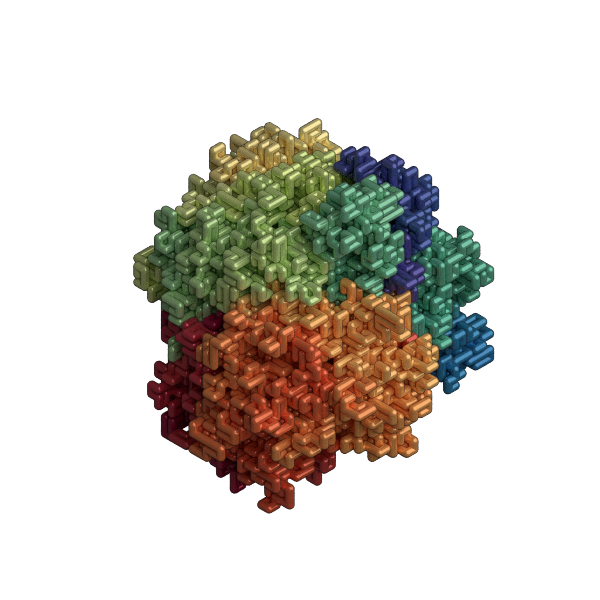

In [10]:
# Or go for fancy rendering using raycasting (slower!)
render.fresnel(snapshot, cmap="Spectral").static(pathtrace=True)

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.05
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 3.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [16]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces

In [17]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [18]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [19]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [20]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           5350.58391     0:00:35.510143           1.02740          
       20000           5917.86714     0:00:30.416364           1.01481          
       30000           6138.89383     0:00:27.692285           1.02339          
       40000           6247.73807     0:00:25.609268           1.03333          
       50000           6319.42182     0:00:23.736349           1.00896          
       60000           6368.35452     0:00:21.983701           1.02953          
       70000           6403.60642     0:00:20.301060           1.02668          
       80000           6426.88154     0:00:18.671575           1.01666          
       90000           6447.14283     0:00:17.061821           1.01387          
      100000           6465.48463     0:00:15.466745           1.00814          
      110000           6477.52743     0:00:13.894190           1.02136          
      120000           6490.

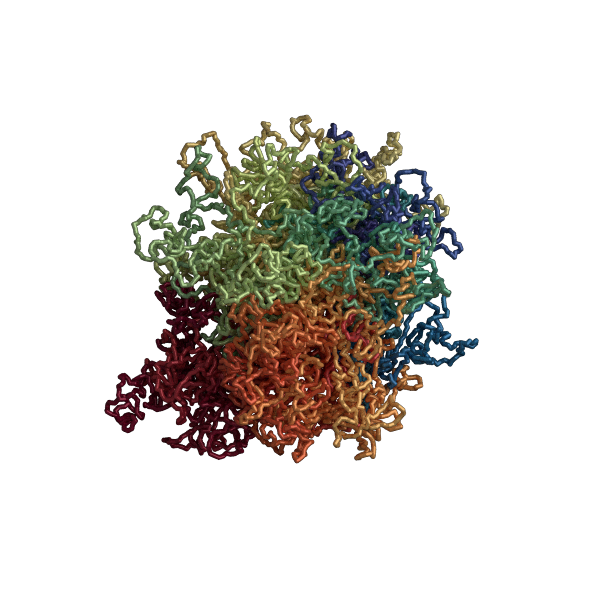

In [21]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="Spectral").static(pathtrace=True)

In [22]:
# Compute contact map
matrix = np.zeros((snapshot_relaxed.particles.N, snapshot_relaxed.particles.N))
contacts = polymer_analyses.calculate_contacts(snapshot_relaxed.particles.position, cutoff=5)

for x, y in contacts:
    matrix[x, y] += 1
    matrix[y, x] += 1

Text(0.5, 1.0, 'Contact map of a single conformation')

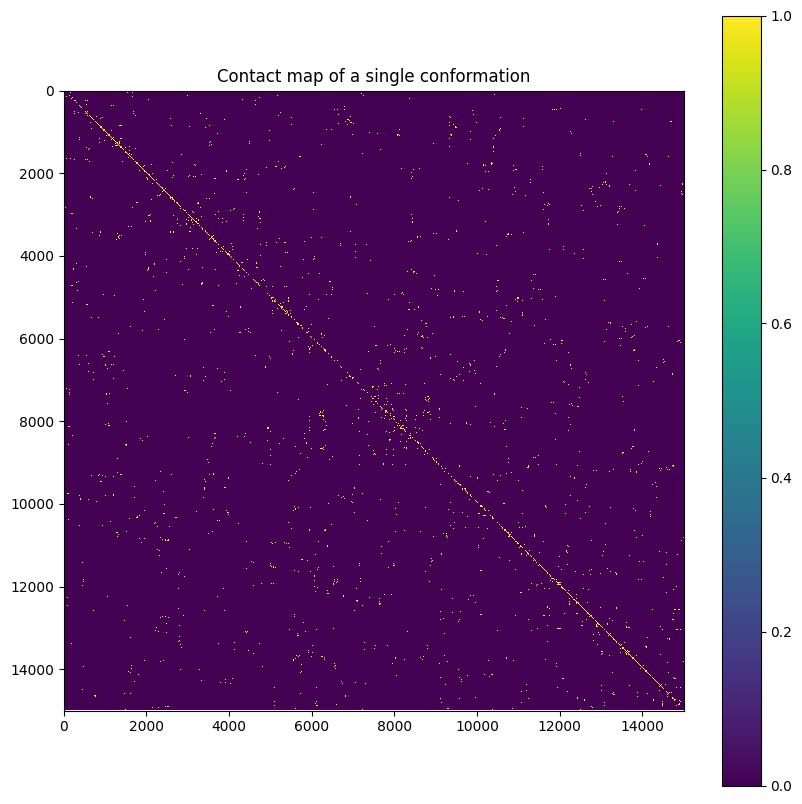

In [23]:
plt.figure(figsize=(10,10))

plt.imshow(matrix, vmax=1, interpolation="none")

plt.colorbar()
plt.title('Contact map of a single conformation')

In [24]:
# Compute contacts vs. distance curve via polykit
dist, ps = polymer_analyses.contact_scaling(snapshot_relaxed.particles.position, cutoff=5)

In [25]:
# Translate contact matrix to Cooler and create view
clr = contact_maps.coolify(matrix, 'single_conformation')

view_df = cooltools.lib.make_cooler_view(clr)

In [26]:
# Compute contacts vs. distance curve via cooltools (https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html)
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=view_df,
    smooth=True,
    aggregate_smoothed=True,
    nproc=4
)

dist_clr, ps_clr = cvd['dist'], cvd['balanced.avg.smoothed.agg']
ps_clr.loc[dist_clr < 2] = np.nan

INFO:root:creating a Pool of 4 workers
/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/tmp/SLURM_24634204/ipykernel_2944/4128784940.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_clr.loc[dist_clr < 2] = np.nan


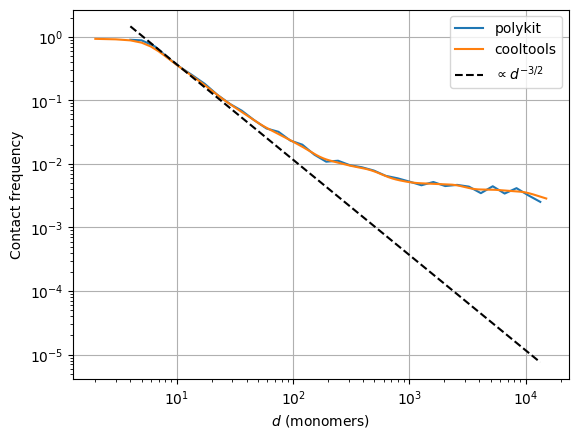

In [27]:
# Compare cooltools & polykit results
plt.loglog(dist, ps, label='polykit')
plt.loglog(dist_clr, ps_clr, label='cooltools')

plt.loglog(dist, ps[2]*(np.asarray(dist)/dist[2])**-1.5, 'k--', label=r"$\propto d^{-3/2}$")

plt.legend(loc='best')

plt.xlabel(r'$d$ (monomers)')
plt.ylabel('Contact frequency')

plt.grid(True)